In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.pathway import KEGGPathwayParser, GenomeGBK, add_pathways_to_deseq_df, show_pathways_in_ranked_genes
from dokdonia.utils import take_average_values, saveToPickleFile, readFromPickleFile

%matplotlib inline


root_dir = Path(os.getcwd())
results_dir = root_dir / "results"
data_dir = root_dir / "data"

## Load counts

In [2]:
min_count = 10

counts = pd.read_csv(data_dir / 'counts' / 'DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)

## Load KEGG pathways and genome annotations

In [3]:
gbk = GenomeGBK(data_dir / 'genome' / 'DokdoniaMED134.gbk')

KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
# gene_info = KEGGparser.getGeneInfoFromKEGGorthology()
gene_list = list(gene_pathways.keys())
print(f'There are a total of {len(gene_list)} genes')

There are a total of 783 genes


## Compute Transcript / cell values

In [4]:
sample_meta = pd.read_excel(data_dir / "normalization" / "Datos_Dokdonia_9Jun23.xlsx")
sample_meta["Sample"] = sample_meta['Light/Dark'] + '_' + sample_meta['Temperature'].astype(str) + '_' + sample_meta['Replicate']
sample_meta.head()

,Temperature,Light/Dark,Replicate,Total biovolume (um3),Total abundance (cells),Avg_Standard_ratio,Sample
0,10,L,R1,2.294207e+08,7.609607e+08,7128.171978,L_10_R1
1,10,L,R2,1.803365e+08,5.434251e+08,22976.436275,L_10_R2
2,10,L,R3,1.960539e+08,6.095364e+08,20778.875834,L_10_R3
3,10,D,R1,1.841892e+08,5.789344e+08,12210.079577,D_10_R1
4,10,D,R2,1.900776e+08,5.737051e+08,18207.999370,D_10_R2


In [5]:
TC = DE.get_transcript_cell(counts, sample_meta, ["D_25_R1", "D_18_R2", "L_10_R1"]).set_index("index")
TC.to_csv(data_dir / "processed" / "DokdoniaMED134_TC.tsv", sep="\t")
TC.head()

,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_25_R2,D_25_R3,D_34_R1,D_34_R2,D_34_R3,D_34_R4,...,L_10_R3,L_18_R1,L_18_R3,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
index,,,,,,,,,,,,,,,,,,,,,
MED134_07389,0.273608,0.362633,0.314843,1.400648,1.168274,1.291959,1.606026,1.354968,1.020768,1.118174,...,0.408360,0.986825,0.569171,0.853985,1.864628,0.917180,0.846804,0.944030,1.231293,1.381038
MED134_07384,0.032838,0.049352,0.036875,0.190266,0.162741,0.178013,0.235689,0.193355,0.163183,0.178798,...,0.054271,0.133927,0.071381,0.117324,0.247419,0.131755,0.115207,0.144760,0.193405,0.186689
MED134_07379,0.071708,0.105337,0.077766,0.330129,0.273291,0.346903,0.419416,0.335165,0.274610,0.303465,...,0.111541,0.220965,0.127431,0.196782,0.402950,0.211308,0.217327,0.232085,0.325291,0.330180
MED134_07374,0.041907,0.067411,0.033359,0.160491,0.119682,0.142566,0.151663,0.133189,0.077265,0.113403,...,0.054748,0.110957,0.060803,0.077639,0.160626,0.086416,0.088775,0.094333,0.118390,0.127110
MED134_07369,0.044016,0.063792,0.050157,0.172611,0.124735,0.129111,0.177424,0.134795,0.077241,0.123901,...,0.066100,0.134110,0.082149,0.080215,0.185833,0.093155,0.117812,0.108562,0.122452,0.122979


## Remove Light/Dark DE genes from datasets

In [6]:
DE_all_T = readFromPickleFile(results_dir / "deseq_results" / "DE_all_T.pkl")
DE_genes_across_T = readFromPickleFile(results_dir / "deseq_results" / "DE_genes_across_T.pkl")


# Remove light-dark DE genes from TC dataset
TCnoDE = TC.loc[(
    (~TC.index.isin(DE_all_T))
    )]

# Find clusters based on expression pattern across temperatures: transcript / cell


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Monday 17 July 2023 (16:01:32)                       |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

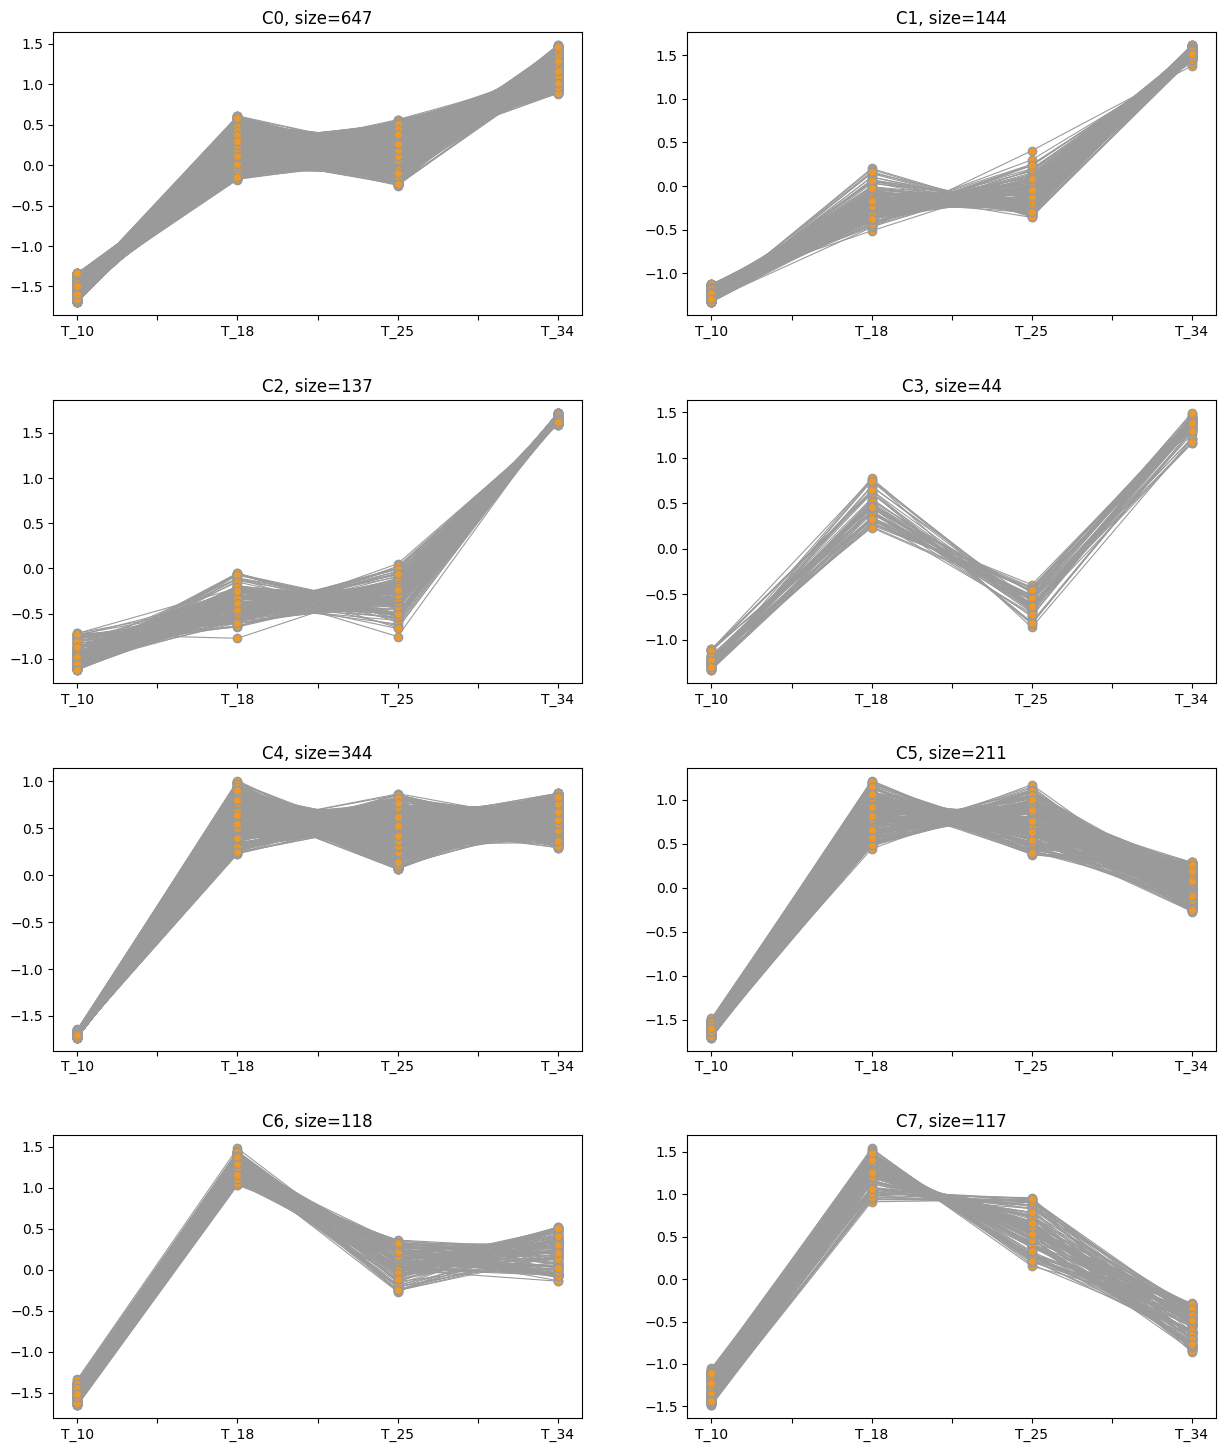

In [7]:
# Using Transcripts/cell
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_NEW_TRANSCRIPT_CELL_ZSCORES'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_TCZ = CA.getGeneClusters(TCnoDE,path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization_only_zscores.txt',
                              replicates_file='clust_replicates_merged_L_D_noD18L10.txt',  # 'clust_replicates_merged_L_D_volume.txt
                              scaling_factor=1e5)

# Plot clusters
plot_cluster_data_TCZ = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

VI.plotClusters(plot_cluster_data_TCZ, clusters_TCZ)

## Merge clusters

Merge into 3 groups. Also add a new cluster formed by the genes that correlate negatively with temperature.

In [8]:
# clusters_TCZ = {
#     "C0": clusters_TCZ["C0"] + clusters_TCZ["C1"],
#     "C1": clusters_TCZ["C2"] + clusters_TCZ["C3"],
#     "C2": clusters_TCZ["C4"]
# }

# # Merge clusters in Clust output file
# df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in clusters_TCZ.items() ]))
# df = df.applymap(lambda x: "" if pd.isna(x) else x)

# with open(results_dir / "clust" / f"{res_id}/Clusters_Objects_merged.tsv", "w+") as file:
#     file.write("\t".join([f"{k} ({len(v)} genes)" for k,v in clusters_TCZ.items()]) + "\n")
#     file.write("\t".join(["Genes" for _ in clusters_TCZ]) + "\n")

#     for row in df.values:
#         file.write("\t".join(row) + "\n")

## Plot clusters

There are a total of 1762 clustered genes


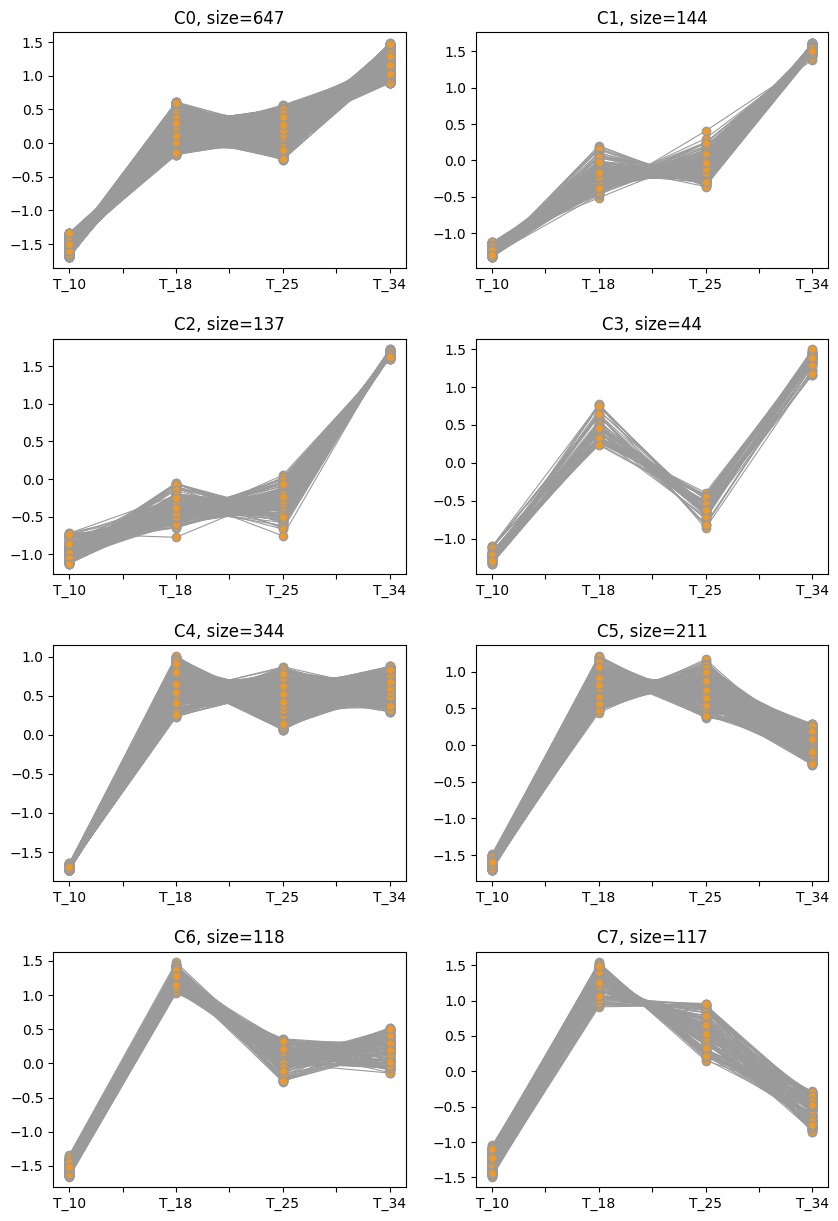

In [9]:
n_genes_in_clusters = sum([len(c) for c in clusters_TCZ.values()])
print(f"There are a total of {n_genes_in_clusters} clustered genes")

# Save figure data
saveToPickleFile(clusters_TCZ, results_dir / "figures" / "figure_data" / "clusters_TCZ.pkl")
saveToPickleFile(plot_cluster_data_TCZ, results_dir / "figures" / "figure_data" / "plot_cluster_data_TCZ.pkl")

VI.plotClusters(plot_cluster_data_TCZ, clusters_TCZ, figsize=(10, 15))

## Annotate and rank genes within clusters

In [10]:
res_id = "CLUSTER_ONLY_TEMP_DE_GENES_NEW_TRANSCRIPT_CELL_ZSCORES"

cluster_data = (1 / 1e5) * pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Input_files_and_params/Data/clust_input.tsv'),
    sep='\t', index_col='index')
ranked_clusters_avg_expr = CA.rankGenesWithinClusters(clusters_TCZ, cluster_data, method="median")


if not (results_dir / "pathways").exists():
   (results_dir / "pathways").mkdir(exist_ok=False)

no_kegg_pathway = []
ranked_clusters = []
for cluster_id in ranked_clusters_avg_expr:
    ranked_df = show_pathways_in_ranked_genes(
        ranked_clusters_avg_expr[cluster_id],
        gbk, gene_pathways,
        gene_systems, n=None
        )
    no_kegg_pathway.append( 100 * (ranked_df[((ranked_df.subsystem.str.contains("Unspecified")) & ~ ranked_df.subsystem.isna())].shape[0]) / ranked_df.shape[0] )
    ranked_df.insert(0, "cluster", cluster_id)
    ranked_df.to_csv(results_dir / "pathways" / f"ranked_{cluster_id}_TCZ.csv")
    ranked_clusters.append(ranked_df)

merged_ranked_clusters = pd.concat(ranked_clusters).sort_values(by="value", ascending=False)
merged_ranked_clusters.to_csv(results_dir / "pathways" / "ranked_clusters_TCZ.csv")
print(no_kegg_pathway)
print(np.mean(no_kegg_pathway))

[75.73415765069552, 86.80555555555556, 87.5912408759124, 72.72727272727273, 72.67441860465117, 71.56398104265404, 82.20338983050847, 64.1025641025641]
76.67532254872674
